# Investigation of seed genes from missed orthologs

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import json
from bs4 import BeautifulSoup
import lxml

In [3]:
# extract seed genes
tools_ref = ['bbh', 'domainoid', 'ensemble', 'hieranoid', 'inparanoid', 'metaphors', 'oma_pairs', 'orthoffgc', 'orthofinder', 'orthoinspector', 'panther', 'rsd', 'sonicparanoid']
tools_human_proteom = ['fdog_assembly_human_proteom_augustus_5t_cov_50', 'fdog_assembly_human_proteom_metaeuk_sens_5t_cov_50']
path = '../../results/qfo_input/human_proteom/'

In [4]:
def create_set_of_sets(path):
    file = open(path, 'r')
    pairs_set = set()
    lines = file.readlines()
    for line in lines:
        line = line.rstrip()
        pairs = frozenset(line.split('\t'))
        pairs_set.add(pairs)
    #print(len(lines))
    print(len(pairs_set))
    return pairs_set

In [5]:
list_of_sets_ref = []
dict_of_sets = {}
for i in tools_ref:
    #pairs_set = create_set_of_sets(path + i + '.tsv')
    #pairs_set = create_set_of_sets(path + i + '_5t.tsv')
    pairs_set = create_set_of_sets(path + i + '_5t.tsv')
    list_of_sets_ref.append(pairs_set)
    dict_of_sets[i] = pairs_set

6027
10002
21850
7223
8366
10256
9445
6071
9651
7832
12511
6069
11938


In [6]:
intersection_all = set.intersection(*list_of_sets_ref)
print(len(list_of_sets_ref))
print(len(intersection_all))

13
3550


In [7]:
list_of_sets = []
for t in tools_human_proteom:
    print(t)
    #pairs_set = create_set_of_sets(path + t + '.tsv')
    pairs_set = create_set_of_sets(path + t + '.tsv')
    list_of_sets.append(pairs_set)
    dict_of_sets[t] = pairs_set

fdog_assembly_human_proteom_augustus_5t_cov_50
7374
fdog_assembly_human_proteom_metaeuk_sens_5t_cov_50
7613


In [8]:
not_found_lists = []
for i in range(len(tools_human_proteom)):
    print(tools_human_proteom[i])
    intersection_size = len(list_of_sets[i].intersection(intersection_all))
    not_found = intersection_all - list_of_sets[i]
    not_found_lists.append(not_found)
    print(intersection_size)
    print(intersection_size/len(intersection_all))

fdog_assembly_human_proteom_augustus_5t_cov_50
3095
0.8718309859154929
fdog_assembly_human_proteom_metaeuk_sens_5t_cov_50
3164
0.8912676056338028


In [9]:
# create a human table
def create_human_dict(intersection_all, not_found_fda):
    dict_human = {'pair': [], 'found': [], 'length': [], 'exons': [], 'lcr': []}
    id_set = set()
    for i in intersection_all:
        dict_human['pair'].append(i)
        id_set.update(i)
        if i in not_found_fda:
            dict_human['found'].append('no')
        else:
            dict_human['found'].append('yes')
    return dict_human, id_set

In [49]:
## Augustus
human_dict_augustus, id_set = create_human_dict(intersection_all, not_found_lists[0])
#print(human_dict_augustus)

In [24]:
def read_human_fasta(fasta, id_set):
    file = open(fasta, 'r')
    lines = file.readlines()
    length_dict = {}
    in_set = False
    for line in lines:
        line = line.rstrip()
        if line[0] == '>':
            protid = line[1:]
            if protid in id_set:
                in_set = True
                #print('True')
            else:
                in_set = False
        else:
            if in_set == True:
                length_dict[protid] = len(line)
    return length_dict
    

In [25]:
human_fasta = '/share/gluster/Projects/hannah/fDOG-assembly/benchmark/data/fDOG/human_seed_genes/HOMSA@9606@240410.fa'
length_dict = read_human_fasta(human_fasta, id_set)
print(len(length_dict))

3064


In [26]:
def read_anno(file, id_set, len_ref):
    f = open(file)
    json_dict = json.load(f)
    seg_dict = {}
    for i in id_set:
        try:
            length = json_dict['feature'][i]['length']
            seg = json_dict['feature'][i]['seg']
            if seg == {}:
                seg_dict[i] = 0
            else:
                lcr_len = 0
                for s in seg["seg_low_complexity_regions"]["instance"]:
                    lcr_len += int(s[1]) - int(s[0])
                seg_dict[i] = lcr_len/int(length)
        except KeyError:
            continue
    f.close()
    return seg_dict

In [27]:
human_anno_file = '/share/gluster/Projects/hannah/fDOG-assembly/benchmark/data/fDOG/annotation_dir/HOMSA@9606@240410.json'
seg_dict = read_anno(human_anno_file, id_set, length_dict)

In [15]:
def read_xml(data, id_set):
    soup = BeautifulSoup(data, "xml")
    accession_counts = {}    
    # Alle gnEntry Einträge durchsuchen
    for entry in soup.find_all("gnEntry"):
        accessions = entry.find_all("accession")
        for ac in accessions:
            if ac.text in id_set:
                max_exon = 0
                for gnCoo in entry.find_all("gnCoordinate"): 
                    exons = gnCoo.find_all("exon")
                    #print(exons)
                    #break
                    if len(exons) > max_exon:
                        max_exon = len(exons)
                accession_counts[ac.text] = len(exons)
            else:
                continue
    return accession_counts

In [16]:
#important xml does not contain info of all human uniprot genes part of the intersection_all group!!!!
file = '/share/gluster/Projects/hannah/fDOG-assembly/benchmark/data/qfo_eukaryota_2022/qfo_data_2022/Eukaryota/UP000005640_9606_gcoord.xml'
with open(file, "r", encoding="utf-8") as file:
    xml_content = file.read()
    print('finished reading')
    exon_count = read_xml(xml_content, id_set)

finished reading


In [28]:
print(len(exon_count))

2994


In [29]:
def update_human_dict(human_dict, length, lcr, exons):
    human_seeds = []
    for pair in human_dict['pair']:
        g1, g2 = pair
        try:
            prot_len = length[g1]
            seed = g1
        except KeyError:
            try:
                prot_len = length[g2]
                seed = g2
            except KeyError:
                print(pair)
        lcr_value = lcr[seed]
        try:
            exon_count = exons[seed]
        except KeyError:
            #print(seed)
            #break
            exon_count = None
        human_dict['length'].append(prot_len)
        human_dict['lcr'].append(lcr_value)
        human_dict['exons'].append(exon_count)
        human_seeds.append(seed)
    return human_dict, human_seeds

In [50]:
human_dict_augustus_new, human_seeds = update_human_dict(human_dict_augustus, length_dict, seg_dict, exon_count)
with open("missed_genes_set2/human_seeds.txt", "w") as file:
    for s in human_seeds:
        file.write(s + "\n")
with open("missed_genes_set2/not_found_augustus.txt", "w") as file:
    for i in not_found_lists[0]:
        x,y = i
        if x in human_seeds:
            file.write(x + "\t" + y + "\n")
        else:
            file.write(y + "\t" + x + "\n")
with open("missed_genes_set2/found_all_prot.txt", "w") as file:
    for i in intersection_all:
        x, y = i
        file.write(x + "\t" + y + "\n")

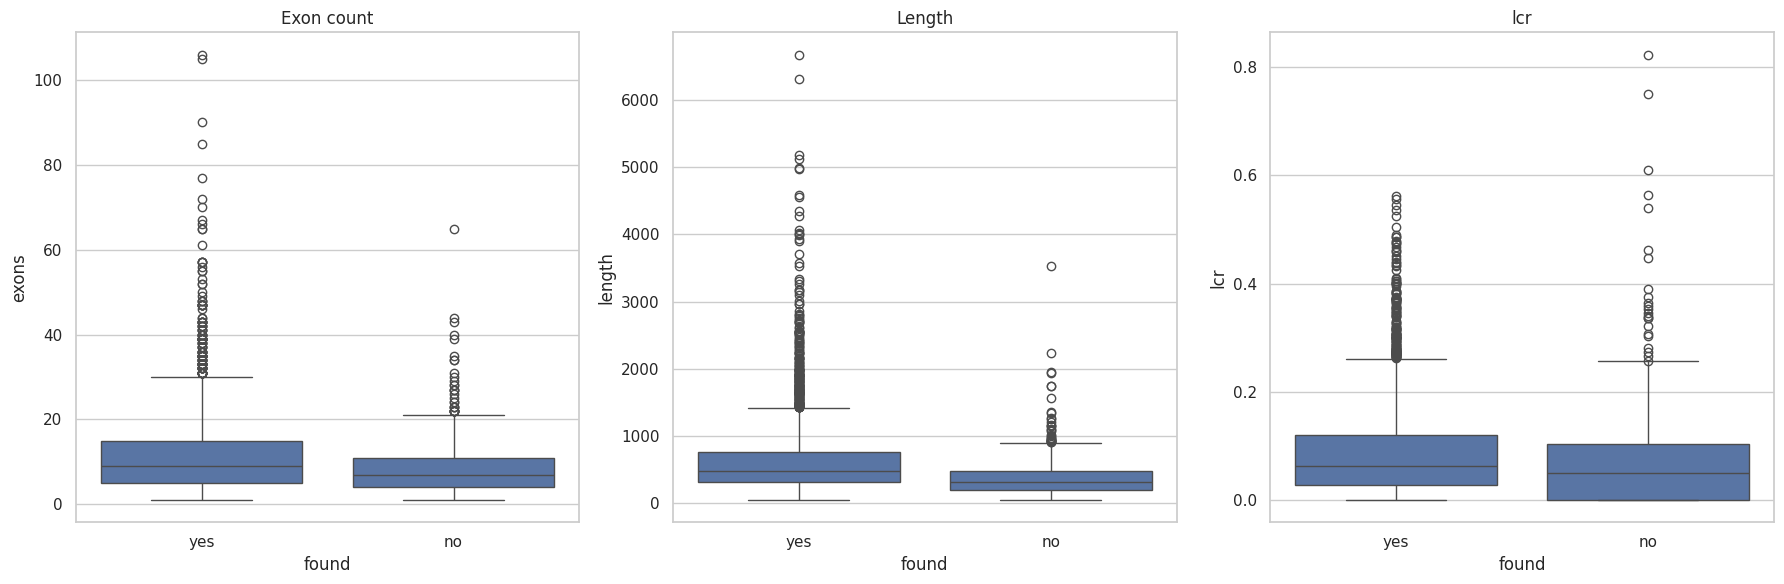

In [56]:
df = pd.DataFrame(human_dict_augustus_new)

sb.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sb.boxplot(data=df, x="found", y="exons", ax=axes[0])
axes[0].set_title("Exon count")

sb.boxplot(data=df, x="found", y="length", ax=axes[1])
axes[1].set_title("Length")

sb.boxplot(data=df, x="found", y="lcr", ax=axes[2])
axes[2].set_title("lcr")

# 📌 Layout anpassen und anzeigen
plt.tight_layout()
#plt.show()
plt.savefig("missed_genes_set2/missed_genes_augustus.svg", bbox_inches='tight')

In [21]:
for key in human_dict_augustus_new:
    print(key)
    print(len(human_dict_augustus_new[key]))

pair
3550
found
3550
length
3550
exons
3550
lcr
3550


In [22]:
max_exon_index = df['exons'].idxmax()
# Retrieve the row with the maximum sales value
max_exon_row = df.loc[max_exon_index]
print(max_exon_row)

pair      (Q2TL32, Q5T4S7)
found                  yes
length                5183
exons                106.0
lcr               0.074667
Name: 1574, dtype: object


In [43]:
#MetaEuk
## Augustus
human_dict_metaeuk, id_set = create_human_dict(intersection_all, not_found_lists[1])


In [44]:
human_dict_metaeuk_new, human_seeds = update_human_dict(human_dict_metaeuk, length_dict, seg_dict, exon_count)
with open("missed_genes_set2/human_seeds.txt", "w") as file:
    for s in human_seeds:
        file.write(s + "\n")
with open("missed_genes_set2/not_found_metaeuk.txt", "w") as file:
    for i in not_found_lists[0]:
        x,y = i
        if x in human_seeds:
            file.write(x + "\t" + y + "\n")
        else:
            file.write(y + "\t" + x + "\n")
with open("missed_genes_set2/found_all_prot.txt", "w") as file:
    for i in intersection_all:
        x, y = i
        file.write(x + "\t" + y + "\n")

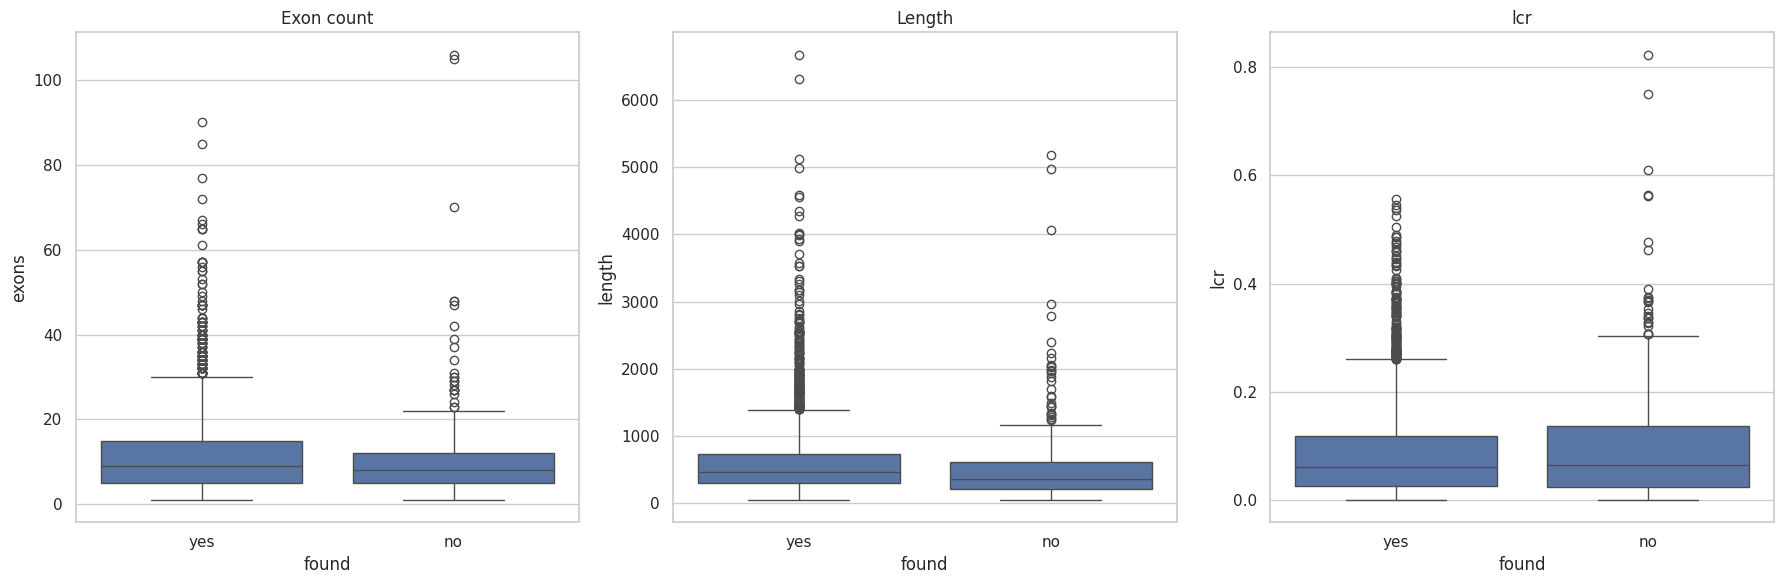

In [57]:
df = pd.DataFrame(human_dict_metaeuk_new)

sb.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sb.boxplot(data=df, x="found", y="exons", ax=axes[0])
axes[0].set_title("Exon count")

sb.boxplot(data=df, x="found", y="length", ax=axes[1])
axes[1].set_title("Length")

sb.boxplot(data=df, x="found", y="lcr", ax=axes[2])
axes[2].set_title("lcr")

# 📌 Layout anpassen und anzeigen
plt.tight_layout()
#plt.show()
plt.savefig("missed_genes_set2/missed_genes_metaeuk.svg", bbox_inches='tight')